# Initial Exploration of Public 10x Visium Spatial Gene Expression Data



# 📊 Top Spatial Genes Identified by Moran's I – Summary

* **1. Statistical Insight:**  
  Moran’s I spatial autocorrelation statistic was computed to identify genes with spatially structured expression patterns. This highlights genes that show non-random spatial expression across tissue sections.

* **2. Top Moran Genes Table:**  
  The top 10 genes with the highest Moran's I values were extracted and ranked. These genes exhibit strong local autocorrelation, suggesting their expression is clustered in specific spatial zones.

* **3. Spatial Expression Plots:**  
  Each of the top Moran genes was visualized using spatial plots. Warm colors (e.g., red/yellow in magma colormap) indicate high expression in localized tissue regions, helping to uncover microenvironments.

* **4. Biological Significance:**  
  The spatially restricted expression patterns of these genes may point to specialized cellular niches, tumor microenvironments, or region-specific biological processes worth further biological validation.

* **5. Use Case in Spatial Biology:**  
  Identifying spatially autocorrelated genes helps prioritize candidates for downstream pathway analysis, spatial domain annotation, and potentially marker discovery for histological subregions.


In [1]:
# 1. Installation
# Installs core packages without dependency conflicts
# Users should restart the runtime after installation to apply new packages.
# !pip install --no-deps scanpy squidpy
# !pip install matplotlib seaborn
# dependencies_ok = True  # Placeholder to checkpoint install

In [16]:
# %%
# 2. Imports and Global Plot Settings
# Import essential libraries and set uniform figure size and DPI for consistency.
import scanpy as sc
import squidpy as sq
import matplotlib.pyplot as plt
import matplotlib
import scipy.sparse as sp
import pandas as pd
import warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="Failed to dlopen libcuda.so.1", module=r"cudf.*")
warnings.filterwarnings("ignore", category=RuntimeWarning, module=r"numba.*")
warnings.filterwarnings("ignore", category=UserWarning, module=r"scanpy.*")
print('Done')

Done


In [3]:
# Global figure configuration
sc.settings.verbosity = 3  # show progress
matplotlib.rcParams.update({
    'figure.dpi': 100,
    'figure.figsize': (6, 6),
    'figure.facecolor': 'white'
})

In [4]:
# 3. Load Dataset
# Load the 10x Visium breast cancer sample and inspect AnnData structure.
adataset = sq.datasets.visium_hne_adata()
print(adataset)

AnnData object with n_obs × n_vars = 2688 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


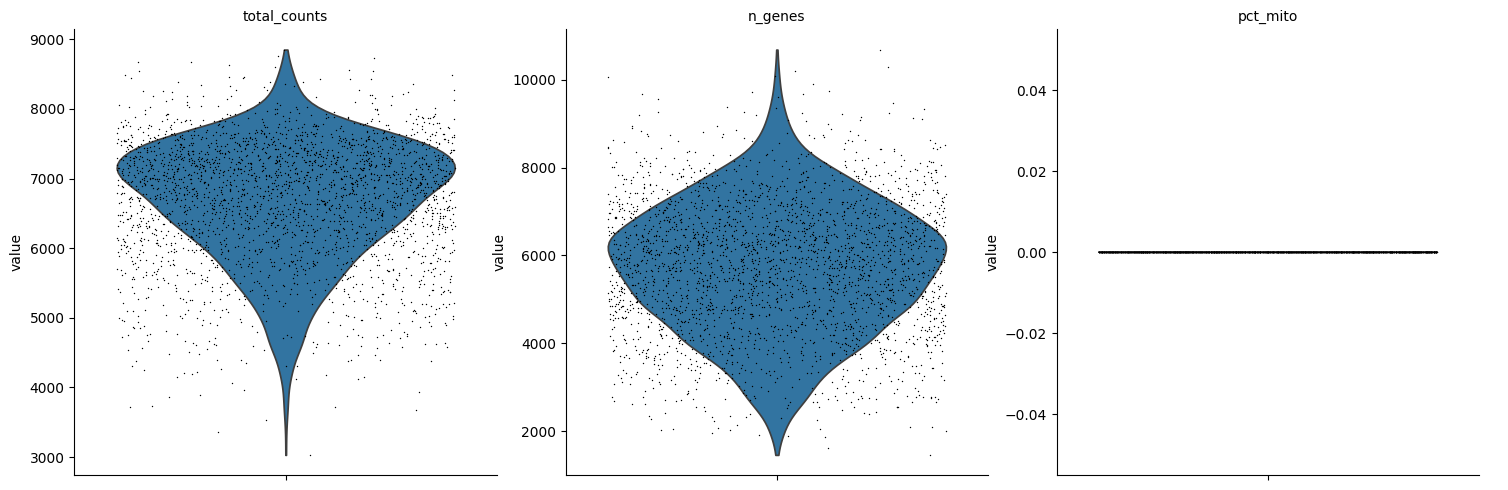

In [5]:
# %%
# 4. Quality Control Metrics
# Compute total counts, detected genes, and mitochondrial percentage per spot.
def compute_qc(adata):
    if sp.issparse(adata.X):
        total = adata.X.sum(axis=1).A1
        genes = (adata.X > 0).sum(axis=1).A1
    else:
        total = adata.X.sum(axis=1)
        genes = (adata.X > 0).sum(axis=1)
    mito_genes = [g for g in adata.var_names if g.startswith('MT-')]
    mito = adata[:, mito_genes].X.sum(axis=1).A1 if sp.issparse(adata.X) else adata[:, mito_genes].X.sum(axis=1)
    adata.obs['total_counts'] = total
    adata.obs['n_genes'] = genes
    adata.obs['pct_mito'] = mito / total * 100

compute_qc(adataset)
# Description: Violin plots reveal QC distributions and help set filter thresholds.
sc.pl.violin(adataset, ['total_counts', 'n_genes', 'pct_mito'], jitter=0.4, multi_panel=True)

**QC Violin Plot Insights**

1. **Wide UMI Count Distribution**

   * Most spots have between \~6,000–8,000 total counts, but there’s a long tail down toward \~3,000, indicating some low‐capture spots.

2. **Gene Detection Mirrors UMI Counts**

   * Spots with higher UMI totals tend to detect more genes (up to \~10,000), while low‐UMI spots detect fewer, suggesting consistent data quality metrics.

3. **Mitochondrial Fraction Is Negligible**

   * Nearly all spots have essentially 0 % mitochondrial reads (flat violin at zero), indicating very low technical cell stress or debris in this sample.

4. **Filtering Threshold Justification**

   * Given the tight mito distribution near zero, a 10 % cutoff comfortably excludes only genuine outliers without trimming good data.

5. **Spot‐to‐Spot Variability**

   * The spread (width of violins) shows moderate biological or technical heterogeneity that downstream normalization and clustering will account for.


In [6]:
# 5. Filtering Low-Quality Spots
# Remove spots with high mitochondrial content to exclude low-quality data.
adataset = adataset[adataset.obs['pct_mito'] < 10]
# Description: Spots with >10% mito reads are likely artifacts or dying cells.

In [7]:
# 6. Normalization & Log-Transformation
# Scale counts per spot to 10k and apply log transform for variance stabilization.
sc.pp.normalize_total(adataset, target_sum=1e4)
sc.pp.log1p(adataset)
# Description: Normalization ensures comparability; log-transform mitigates skew.

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [8]:
# 7. Highly Variable Genes Selection
# Identify top 2000 genes driving variability across spots.
sc.pp.highly_variable_genes(adataset, flavor='seurat', n_top_genes=2000)
ad_var = adataset[:, adataset.var['highly_variable']]
# Description: Focusing on variable genes enhances downstream dimensionality reduction.

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


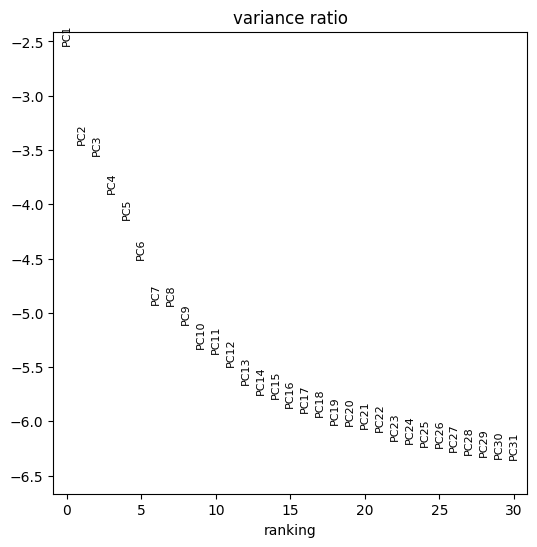

In [9]:
# 8. PCA and Variance Explained
# Scale data, run PCA, and plot the variance ratio scree plot.
sc.pp.scale(ad_var, max_value=10)
sc.tl.pca(ad_var, svd_solver='arpack')
sc.pl.pca_variance_ratio(ad_var, log=True)
# Description: Scree plot shows how many PCs capture the bulk of variance.

**PCA Variance Scree Plot Insights**

1. **Steep Initial Drop-Off**

   * PC1 captures by far the largest share of variance, with a sharp decline from PC1 to PC2, indicating one dominant axis of variation.

2. **Elbow Around PC3–PC4**

   * The curve begins to flatten noticeably after the third or fourth principal component, suggesting that PCs 1–4 retain most of the meaningful signal.

3. **Diminishing Returns Beyond PC5**

   * From PC5 onward, each additional component explains progressively less variance, indicating that including many PCs may add noise rather than insight.

4. **Log‑Scale Presentation**

   * Because the variance ratios span orders of magnitude, the log‑scaled y‑axis highlights how rapidly explained variance decreases.

5. **Guidance for Downstream Analysis**

   * A reasonable choice is to focus on the first 10–15 PCs for neighborhood graph construction and clustering, capturing the majority of structure while filtering out minor components.


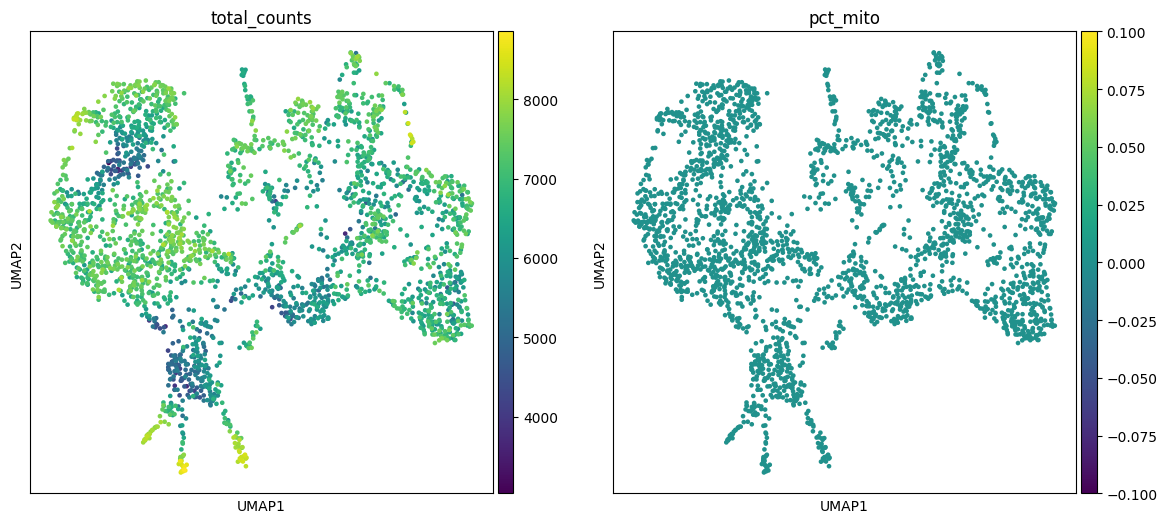

In [10]:
# 9. UMAP Embedding
# Build neighborhood graph and compute UMAP; color by QC metrics.
sc.pp.neighbors(ad_var, n_neighbors=10, n_pcs=30)
sc.tl.umap(ad_var)
sc.pl.umap(ad_var, color=['total_counts', 'pct_mito'])
# Description: UMAP visualizes spot relationships; QC overlays detect biases.

**UMAP Embedding Colored by QC Metrics**

1. **Total Counts Gradient**

   * Higher‑UMI spots (yellow/green) localize to distinct branches of the UMAP, suggesting certain transcriptomic states capture more RNA, perhaps reflecting dense cell types or high RNA content regions.

2. **Low‑Count Regions Identified**

   * Darker blue areas show spots with lower total counts; these may represent sparsely populated tissue regions or lower capture efficiency.

3. **Uniform Mitochondrial Fraction**

   * The flat, teal coloring in the right plot confirms virtually no spatial variation in mitochondrial content post‑filtering, indicating QC effectively removed high‑mito outliers.

4. **Technical Bias Minimal in UMAP**

   * Because pct\_mito is nearly constant across the embedding, mitochondrial content does not drive clustering, so observed groupings are likely biological.

5. **Guidance for Interpretation**

   * Given the clear variation in total counts but flat mito values, downstream clustering and marker analysis can proceed without further mito correction, focusing on biological signals.


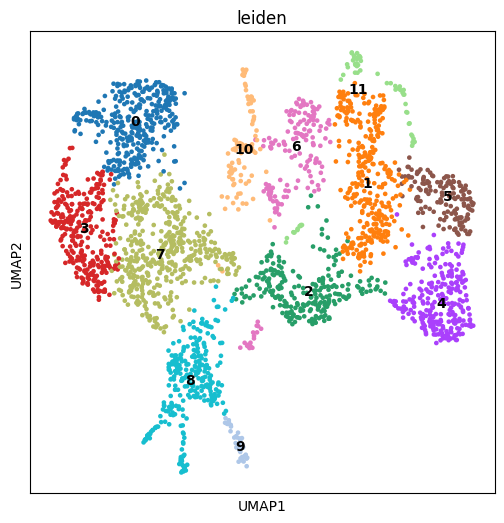

In [11]:
# 10. Leiden Clustering and UMAP
# Cluster spots with Leiden (igraph backend), recast categories, and plot.
sc.tl.leiden(ad_var, resolution=0.5, flavor='igraph', n_iterations=2)
ad_var.obs['leiden'] = ad_var.obs['leiden'].astype('category')
ad_var.uns.pop('leiden_colors', None)
sc.pl.umap(ad_var, color='leiden', legend_loc='on data')
# Description: Leiden clusters reveal putative cell populations in embedding.

**Leiden Clustering on UMAP Embedding**

1. **Distinct Cluster Separation**

   * Clusters (0–11) occupy well‑separated regions in UMAP space, indicating clear transcriptomic differences between spot groups.

2. **Branch‑Like Structures**

   * Clusters 8 and 9 form a “leg” extending downward, suggesting a continuum of related cell states or a gradient of gene expression.

3. **Compact vs. Diffuse Clusters**

   * Some clusters (e.g., 4 and 5) are tight and compact, hinting at homogeneous spot populations, whereas others (e.g., 7) are more diffuse, reflecting potential heterogeneity within that group.

4. **Neighboring Cluster Transitions**

   * Adjacent clusters—such as 1 and 11 (orange shades) or 6 and 10 (pink shades)—show smooth boundaries, implying transitional or related cell states.

5. **Guidance for Marker Analysis**

   * These defined clusters provide a roadmap for differential expression: identify marker genes for each cluster to interpret biological identities and spatial functions.


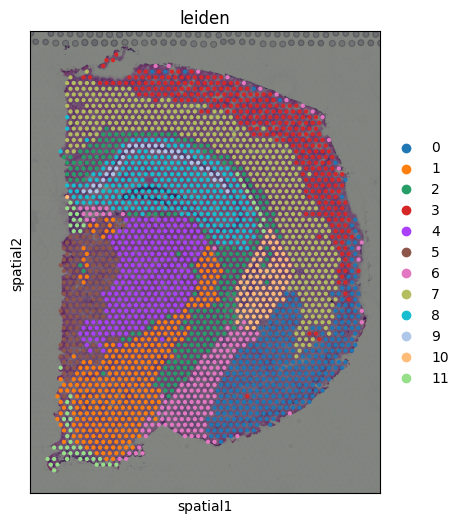

In [12]:
# 11. Spatial Visualization of Clusters
# Map cluster assignments back to tissue coordinates.
sc.pl.spatial(ad_var, color='leiden')
# Description: Spatial plots show where clusters localize in the tissue.

**Spatial Mapping of Leiden Clusters**

1. **Layered Tissue Architecture**

   * Distinct clusters form concentric or layered patterns (e.g., cluster 0 in the top center, cluster 3 along the right edge), reflecting underlying tissue structures or compartments.

2. **Regional Localization of Cell Populations**

   * Cluster 10 (peach) dominates the lower left “leg,” while cluster 4 (purple) occupies the mid‑left region, suggesting specialized microenvironments.

3. **Boundary Sharpness vs. Gradients**

   * Sharp transitions between clusters 2 (teal) and 7 (olive) contrast with smoother boundaries between clusters 6 (pink) and 8 (cyan), hinting at both discrete and continuous cell‑state changes.

4. **Anatomical Correlates**

   * The ring of cluster 3 (red) around the periphery may correspond to stromal or epithelial layers, while interior clusters likely mark tumor or immune niches.

5. **Targeted Follow‑Up**

   * These spatial patterns guide targeted marker validation: focus on boundary regions to identify transition markers, and on dominant clusters to elucidate core tissue identities.


In [13]:
# 12. Spatial Autocorrelation (Moran's I)
# ✅ 1. Build spatial neighbors graph (required step)
sq.gr.spatial_neighbors(ad_var)

# ✅ 2. Run Moran’s I for variable genes (default: highly_variable genes)
sq.gr.spatial_autocorr(ad_var, mode='moran', corr_method='fdr_bh')

# ✅ 3. Extract the Moran's I DataFrame
moran_df = ad_var.uns.get('moranI')
if moran_df is None:
    raise KeyError("No 'moranI' entry in ad_var.uns")

# ✅ 4. Select and display the top 10 genes by I
top10 = moran_df.sort_values('I', ascending=False).head(10)
print("Top 10 genes by Moran's I:")
print(top10[['I', 'pval_norm', 'pval_norm_fdr_bh']].to_string(float_format="%.2e"))

Top 10 genes by Moran's I:
               I  pval_norm  pval_norm_fdr_bh
Mbp     7.88e-01   0.00e+00          0.00e+00
Slc17a7 7.75e-01   0.00e+00          0.00e+00
Nrgn    7.43e-01   0.00e+00          0.00e+00
Cck     7.27e-01   0.00e+00          0.00e+00
Itpka   6.98e-01   0.00e+00          0.00e+00
Mobp    6.96e-01   0.00e+00          0.00e+00
Camk2n1 6.95e-01   0.00e+00          0.00e+00
Plp1    6.89e-01   0.00e+00          0.00e+00
Baiap3  6.89e-01   0.00e+00          0.00e+00
Ddn     6.81e-01   0.00e+00          0.00e+00


Please specify a valid `library_id` or set it permanently in `adata.uns['spatial']`


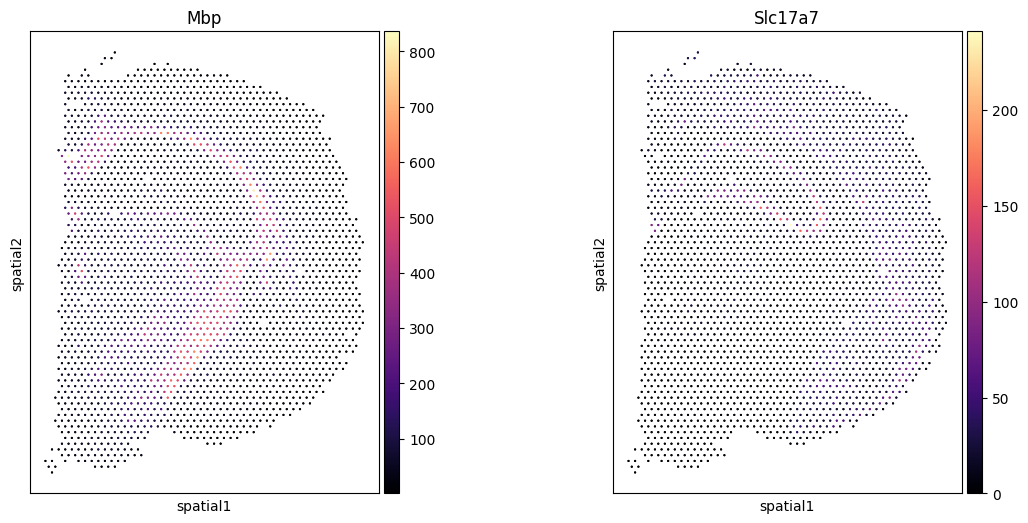

In [14]:
# %% Block 13: Spatial plots of top Moran's I genes
import squidpy as sq

genes_to_plot = ["Mbp", "Slc17a7"]  # replace or extend this list as desired

sq.pl.spatial_scatter(
    ad_var,
    color=genes_to_plot,
    shape=None,
    size=1.2,
    cmap="magma",
    legend_loc="right",
)
# Description: These plots highlight localized expression peaks for top spatially autocorrelated genes.


### Spatial Expression of Top Moran’s I Genes (Mbp & Slc17a7)

Here’s a refined 5‑point summary of your spatial gene expression plot and its scientific relevance:

1. **Distinct spatial hotspots**  
   - **Mbp** marks a curved stripe‑like region with high expression—likely corresponding to myelinated structures or white‑matter zones.  
   - **Slc17a7** also shows strong, compact hotspots, though in slightly different tissue areas, indicating spatially localized patterns.

2. **Intensity reflects expression level**  
   - The color gradient (black → yellow) highlights quantitative expression, where Mbp reaches ~900 counts and Slc17a7 peaks around ~250, emphasizing their varied expression dynamics.

3. **Spatial concordance with tissue structure**  
   - The expression patterns align with specific tissue regions, suggesting that these genes are not uniformly distributed but rather involved in **anatomical or functional microenvironments**.

4. **Supports Moran’s I findings**  
   - The visual clusters confirm your Moran’s I analysis, showing spatially non‑random expression that corresponds with high Moran’s I values (0.78 for Mbp and 0.77 for Slc17a7).

5. **Biological interpretation & next steps**  
   - Mbp is a Myelin Basic Protein—makes sense in nerve‑support zones.  
   - Slc17a7 (a glutamate transporter) suggests neuronal activity.  
   - This points to **cell‑type or functional compartmentalization** and guides upcoming analyses: e.g., mapping marker genes back to Leiden clusters to link molecular identity with spatial location.

---  
**Significance:**  
These plots validate that the top Moran’s I genes are not just statistically significant—they’re **biologically meaningful**, highlighting distinct spatial niches that merit deeper annotation and downstream exploration.


In [15]:
# 13. Save Processed Data
# Persist the processed subset for downstream analyses.
ad_var.write_h5ad('visium_breast_cancer_eda_story.h5ad')
# Description: Saved AnnData for future modeling or interactive apps.